# Optimierung

Testing and visualizing low-level optimization techniques.

In [ ]:
import matplotlib.pyplot as plt
from utils import compile, execute, decompose_results

## Cache-Based Optimization Techniques

A CPU cache is a low-latency hardware component directly attached to a CPU. When the CPU accesses
data from main memory, it writes them into the cache. When the CPU needs to access main memory
again, it first checks if the data are already in the cache. It's that the case, it retrieves data
from the cache instead of using high-latency main memory. This is called a cache hit. It accelerates
programs because the CPU does not have to waste clock cycles waiting for data to arrive from main
memory.

We can accelerate programs by writing them in a way that maximizes cache hits to reduce the time
waiting for data from main memory. The key for that is the **principle of locality**. We want to use
the data in the cache before accessing the main memory again, and that can be accomplished by
accessing data that sit in the same block of memory.

An algorithm is called **cache-aware** if it is optimized by knowing the size of the cache. It is
called **cache-oblivious** if it is optimized for the cache regardless of its size. The thesis
https://ocw.mit.edu/courses/6-895-theory-of-parallel-systems-sma-5509-fall-2003/6dc7de52dcf13b53cebf2fe10ae6752a_cach_oblvs_thsis.pdf
explains it in detail.

### Cache-Oblivious Matrix Multiplication

Matrix multiplication is really "baby's first cache optimization". We can accelerate a naïve matrix
multiplication by transposing the right-hand matrix and access its rows instead of columns, which
results in fewer cache misses. But a truly cache-oblivious algorithm can be achieved by recursively
performing multiplication and additions.

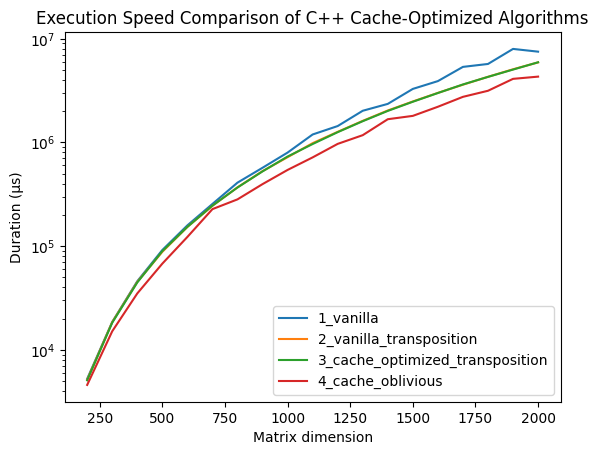

In [52]:
executable = compile("cache/matrix_multiplication")
output = execute(executable)
N, result = decompose_results(output)

fig, ax = plt.subplots()
for technique in result:
    ax.plot(N, result[technique], label=f"{technique}")
ax.set(xlabel='Matrix dimension', ylabel='Duration (μs)')
ax.set_yscale('log')
ax.legend()
ax.set_title("Execution Speed Comparison of C++ Cache-Optimized Algorithms")
plt.show()

Notice:

- The naïve implementation (`1_vanilla`) is the slowest one because of all the cache misses.
- Transposition (`2_vanilla_transposition`) accelerates computations.
- Cache-oblivious transposition (`3_cache_optimized_transposition`) does not provide much benefit
  compared to naïve transposition. It should be faster in theory because it reduces cache misses,
  but the compiler probably has an easier time optimizing the simpler version, which makes it faster
  in practice.
- Cache-oblivious matrix multiplication (`4_cache_oblivious`) is faster because it basically
  combines transposition and multiplication / addition, which reduces cache misses even further.

In [50]:
A = result["1_vanilla"][-1]
B = result["2_vanilla_transposition"][-1]
D = result["4_cache_oblivious"][-1]
print(f"The transposition-based algorithm completed in {B / A * 100:.5} % of the time taken by the naïve implementation.")
print(f"The cache-oblivious algorithm completed in {D / A * 100:.5} % of the time taken by the naïve implementation.")

The transposition-based algorithm completed in 79.167 % of the time taken by the naïve implementation.
The cache-oblivious algorithm completed in 97.619 % of the time taken by the naïve implementation.


Would that work in Python?

The transposition-based algorithm completed in 638.44 % of the time taken by the naïve implementation.


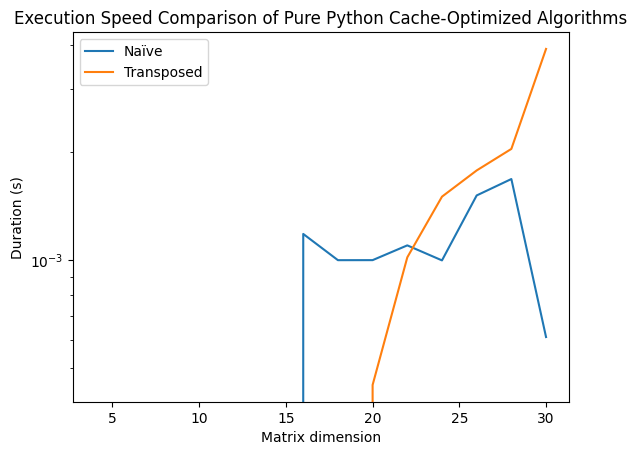

In [ ]:
from random import uniform
from time import time


def create_matrix(size: int) -> list[list[float]]:
    return [[uniform(-1.0, 1.0) for _ in range(size)] for _ in range(size)]


def naive_matmul(A, B, C):
    N = len(A)
    for i in range(N):
        for j in range(N):
            C[i][j] = 0.0
            for k in range(N):
                C[i][j] += A[i][k] * B[k][j]


def transpose_matmul(A, B, C):
    N = len(A)

    def transpose(M: list[list[float]]):
        for i in range(N):
            for j in range(i):
                tmp = M[i][j]
                M[i][j] = M[j][i]
                M[j][i] = tmp

    transpose(B)
    for i in range(N):
        for j in range(N):
            C[i][j] = 0.0
            for k in range(N):
                C[i][j] += A[i][k] * B[j][k]


naive_durations = []
transpose_durations = []
N = range(100, 600, 100)
for n in N:
    A = create_matrix(n)
    B = create_matrix(n)
    C = [[0 for _ in range(n)] for _ in range(n)]
    a = time()
    naive_matmul(A, B, C)
    b = time()
    transpose_matmul(A, B, C)
    c = time()
    naive_durations.append(b - a)
    transpose_durations.append(c - b)

A = naive_durations[-1]
B = transpose_durations[-1]
print(f"The transposition-based algorithm completed in {B / A * 100:.5} % of the time taken by the naïve implementation.")
fig, ax = plt.subplots()
ax.plot(list(N), naive_durations, label="Naïve")
ax.plot(list(N), transpose_durations, label="Transposed")
ax.set(xlabel='Matrix dimension', ylabel='Duration (s)')
ax.set_yscale('log')
ax.legend()
ax.set_title("Execution Speed Comparison of Pure Python Cache-Optimized Algorithms")
plt.show()

Optimizing for the cache **does** lead to a performance gain in pure Python, but it can be smaller
than in C++ because Python lists are more abstracted than C++ vectors:

- C++ vectors or arrays are stored in contiguous locations, so row indexing is much more
  cache-friendly than accessing columns.
- Python lists contain pointers to Python Objects. The pointers are contiguous in memory, but they
  may point at arbitrary memory locations. So iterating over rows is faster than iterating over
  columns because the pointers are stored in a cache-friendly way, but fetching the *values* pointed
  by pointers not necessarily is. It's actually not cache-friendly at all if the memory allocator
  places the values at random locations, but if the allocator places them at contiguous locations,
  it benefits from cache optimization.

Of course, it's much simpler to use a library dedicated to linear algebra like BLAS or Numpy to
perform that kind of operation because they implement that sort of optimization out of the box.

### Cache-Oblivious Fast Fourier Transform (FFT)

